In [223]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

In [224]:
# Load the data
file_path = "accident_data.csv"  # Update this with the actual file path
df = pd.read_csv(file_path)
print(f"Initial dataset size: {df.shape}")

Initial dataset size: (324, 11)


In [225]:

# Convert "Incident Date" to datetime and calculate days after August 1, 2022
reference_date = datetime(2022, 8, 1)
df["Incident Date"] = pd.to_datetime(df["Incident Date"], format="%m/%d/%Y", errors='coerce')
df = df[df["Incident Date"] >= reference_date]
df["Days After Reference"] = (df["Incident Date"] - reference_date).dt.days

print(f"Initial dataset size: {df.shape}")

Initial dataset size: (318, 12)


In [226]:

# Filter rows where "Is NHTSA Reportable In-Transport" is TRUE

df["Is NHTSA Reportable In-Transport"] = df["Is NHTSA Reportable In-Transport"].astype(str).str.strip().str.title()
df = df[df["Is NHTSA Reportable In-Transport"] == "True"]

print(f"Initial dataset size: {df.shape}")

Initial dataset size: (295, 12)


In [227]:
# Compute Severity Score
df["Severity Score"] = 0

df["Is Airbag Deployment"] = df["Is Airbag Deployment"].astype(str).str.strip().str.title()
df["Is Any-Injury-Reported"] = df["Is Any-Injury-Reported"].astype(str).str.strip().str.title()

df.loc[df["Is Airbag Deployment"] == "True", "Severity Score"] += 5
df.loc[df["Is Any-Injury-Reported"] == "True", "Severity Score"] += 8

print(f"Initial dataset size: {df.shape}")

Initial dataset size: (295, 13)


In [228]:

# Prepare data for regression
X = df[["Days After Reference"]].values
y = df["Severity Score"].values

print(f"Initial dataset size: {df.shape}")

Initial dataset size: (295, 13)


In [229]:

# Perform linear regression
model = LinearRegression()
model.fit(X, y)

print(f"Initial dataset size: {df.shape}")

Initial dataset size: (295, 13)


In [230]:

# Print regression coefficients
print(f"Intercept: {model.intercept_}")
print(f"Slope: {model.coef_[0]}")

print(f"Initial dataset size: {df.shape}")

Intercept: 1.1357743982675679
Slope: -0.0002823300495181964
Initial dataset size: (295, 13)


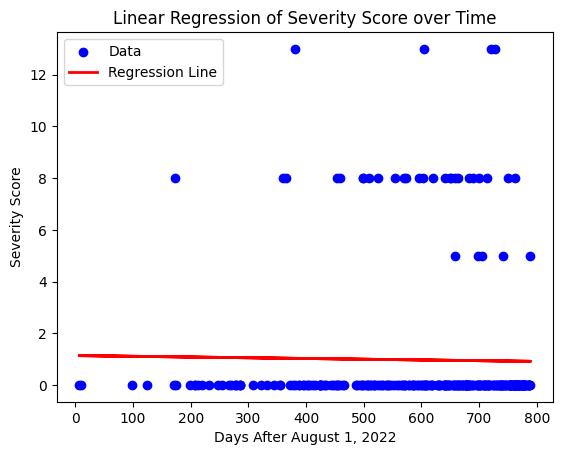

Initial dataset size: (295, 13)


In [231]:

# Plot the results
plt.scatter(X, y, color='blue', label='Data')
plt.plot(X, model.predict(X), color='red', linewidth=2, label='Regression Line')
plt.xlabel("Days After August 1, 2022")
plt.ylabel("Severity Score")
plt.title("Linear Regression of Severity Score over Time")
plt.legend()
plt.show()

print(f"Initial dataset size: {df.shape}")

In [232]:
file_path = "accident_data.csv"  # Update this with the actual file path
df = pd.read_csv(file_path)
print(f"Initial dataset size: {df.shape}")
print(df.head())


Initial dataset size: (324, 11)
  SGO Report ID  Year Month       Location  Is NHTSA Reportable In-Transport  \
0    30270-8887      202409        PHOENIX                             False   
1    30270-8886      202409    LOS_ANGELES                              True   
2    30270-8885      202409  SAN_FRANCISCO                              True   
3    30270-8884      202409  SAN_FRANCISCO                              True   
4    30270-8883      202409         AUSTIN                              True   

   Is NHTSA Reportable In-Transport Delta-V Less than 1 MPH  \
0                                              False          
1                                              False          
2                                               True          
3                                               True          
4                                               True          

   Is Police-Reported  Is Any-Injury-Reported  Is Airbag Deployment  \
0               False                

In [233]:


# Convert "Incident Date" to datetime and calculate days after August 1, 2022
reference_date = datetime(2022, 8, 1)
df["Incident Date"] = pd.to_datetime(df["Incident Date"], format="%m/%d/%Y", errors='coerce')
df = df[df["Incident Date"] >= reference_date]
df["Days After Reference"] = (df["Incident Date"] - reference_date).dt.days

# Filter rows where "Is NHTSA Reportable In-Transport" is TRUE
df = df[df["Is NHTSA Reportable In-Transport"] == "TRUE"]

In [234]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

In [235]:
# -----------------------------------------------------------------
# 1) READ IN THE TWO CSV FILES
# -----------------------------------------------------------------
accidents_df = pd.read_csv("accident_data.csv")
trips_df = pd.read_csv("data/trips.csv")

# -----------------------------------------------------------------
# 2) HELPER FUNCTION TO CONVERT YYYYMM → MONTHS AFTER AUG 2023
# -----------------------------------------------------------------
def months_after_aug2023(yyyymm):
    """
    Given an integer or string of the form YYYYMM, 
    return how many months after 2023-08 it is.
    For example:
        202308 -> 0
        202309 -> 1
        202408 -> 12
        202412 -> 16
    """
    # Convert to string in case it's read as integer
    yyyymm_str = str(yyyymm)
    year = int(yyyymm_str[:4])
    month = int(yyyymm_str[4:])
    
    # Calculate months relative to August 2023 → year=2023, month=8
    return (year - 2023) * 12 + (month - 8)

# -----------------------------------------------------------------
# 3) AGGREGATE ACCIDENTS PER MONTH
#    Count the number of rows in accident_data.csv for each YYYYMM
# -----------------------------------------------------------------
accidents_per_month = (
    accidents_df
    .groupby("Year Month")  # group by the YYYYMM column
    .size()                 # count how many rows in each group
    .reset_index(name="Accident_Count")
)   

# -----------------------------------------------------------------
# 4) AGGREGATE TOTAL WEEKLY TRIPS PER MONTH
#    Sum the "Weekly Trips" column for each YYYYMM in trips.csv
# -----------------------------------------------------------------
trips_df["Weekly Trips"] = trips_df["Weekly Trips"] * 4.3452381
trips_per_month = (
    trips_df
    .groupby("Year Month")      # group by the YYYYMM column
    ["Weekly Trips"]
    .sum()                      # sum up weekly trips for each month
    .reset_index(name="Monthly_Trips")
)

# -----------------------------------------------------------------
# 5) MERGE ACCIDENTS + TRIPS BY YYYYMM, RESTRICT TO AUG 2023→DEC 2024
# -----------------------------------------------------------------
# Combine accidents_per_month with trips_per_month
merged = pd.merge(accidents_per_month, 
                  trips_per_month, 
                  on="Year Month", 
                  how="outer")  # outer merge in case some months have 0 accidents

# We only care about months from 202308 (Aug 2023) through 202412 (Dec 2024)
min_yyyymm = 202309
max_yyyymm = 202409

# Convert "Year Month" to an integer and filter
merged["Year Month"] = merged["Year Month"].astype(int)
merged = merged[(merged["Year Month"] >= min_yyyymm) & 
                (merged["Year Month"] <= max_yyyymm)]

# Fill any missing accident counts or trip counts with 0 if needed
merged["Accident_Count"] = merged["Accident_Count"].fillna(0)
merged["Monthly_Trips"] = merged["Monthly_Trips"].fillna(0)

# Compute Probability of an accident = (# accidents) / (# rides)
merged["Probability_of_Accident"] = merged.apply(
    lambda row: row["Accident_Count"] / row["Monthly_Trips"] 
    if row["Monthly_Trips"] > 0 
    else 0, 
    axis=1
)

# -----------------------------------------------------------------
# 6) CREATE THE (X, y) FOR THE REGRESSION
#    X = months after Aug 2023, y = probability of an accident
# -----------------------------------------------------------------
merged["Months_After_Aug2023"] = merged["Year Month"].apply(months_after_aug2023)

# Sort by the numeric month so we have them in order
merged = merged.sort_values("Months_After_Aug2023")

X = merged["Months_After_Aug2023"].values.reshape(-1, 1)  # scikit-learn wants a 2D array
y = merged["Probability_of_Accident"].values

# -----------------------------------------------------------------
# 7) FIT A LINEAR REGRESSION MODEL
# -----------------------------------------------------------------
model = LinearRegression()
model.fit(X, y)

# Extract slope (coefficient) and intercept
slope = model.coef_[0]
intercept = model.intercept_

print("Linear Regression Results:")
print(f"  Intercept (probability at month=0 → August 2023): {intercept:.8f}")
print(f"  Slope (change in probability per 1-month increase): {slope:.8f}")

# Optionally, you can make predictions for each month
predictions = model.predict(X)

# -----------------------------------------------------------------
# 8) REPORT OR SAVE RESULTS
# -----------------------------------------------------------------
results_df = merged.copy()
results_df["Predicted_Probability"] = predictions
print("\nSummary of each month:")
print(results_df[[
    "Year Month", 
    "Months_After_Aug2023", 
    "Accident_Count", 
    "Monthly_Trips", 
    "Probability_of_Accident", 
    "Predicted_Probability"
]])

Linear Regression Results:
  Intercept (probability at month=0 → August 2023): 0.00022701
  Slope (change in probability per 1-month increase): -0.00000778

Summary of each month:
    Year Month  Months_After_Aug2023  Accident_Count  Monthly_Trips  \
15      202309                     1            11.0   39007.347264   
16      202310                     2            12.0   55434.865638   
17      202311                     3             5.0   57689.263938   
18      202312                     4            16.0   71223.078052   
19      202401                     5            14.0   75784.596859   
20      202402                     6            11.0   77857.227113   
21      202403                     7            20.0   82271.196321   
22      202404                     8            11.0   93272.708436   
23      202405                     9            30.0  140915.510917   
24      202406                    10            30.0  191462.778002   
25      202407                    11   

In [236]:
from sklearn.metrics import r2_score

Regression Coefficients:
  Intercept (probability at x=0): 0.00022701
  Slope (change in probability per 1-month): -0.00000778
  R-squared: 0.26475982


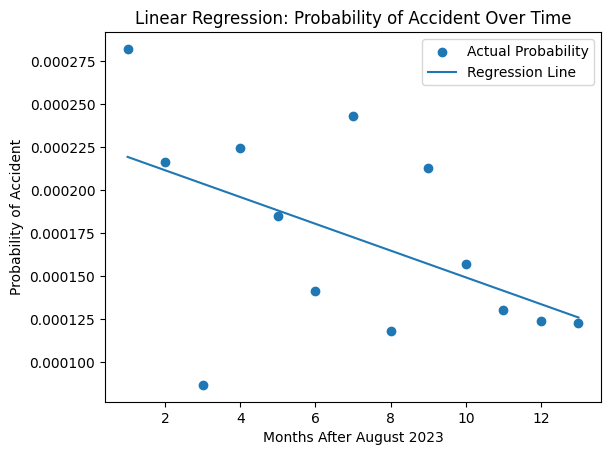

In [237]:
# Extract features (X) and target (y)
X = merged["Months_After_Aug2023"].values.reshape(-1, 1)
y = merged["Probability_of_Accident"].values

# -----------------------------------------------------------------
# 2) Fit linear regression
# -----------------------------------------------------------------
model = LinearRegression()
model.fit(X, y)

# Make predictions
predictions = model.predict(X)

# Compute R^2
r2 = r2_score(y, predictions)

# -----------------------------------------------------------------
# 3) Print regression coefficients
# -----------------------------------------------------------------
print("Regression Coefficients:")
print(f"  Intercept (probability at x=0): {model.intercept_:.8f}")
print(f"  Slope (change in probability per 1-month): {model.coef_[0]:.8f}")
print(f"  R-squared: {r2:.8f}")

# -----------------------------------------------------------------
# 4) Create a chart
# -----------------------------------------------------------------
plt.scatter(X, y, label='Actual Probability')
plt.plot(X, predictions, label='Regression Line')

plt.xlabel('Months After August 2023')
plt.ylabel('Probability of Accident')
plt.title('Linear Regression: Probability of Accident Over Time')
plt.legend()
plt.show()

test

$a^2+b^2=c^2$